In [8]:
#TestFolderPath = "/home/calm/Documents/bill_parser/TestFolder"
TestImagePath = "/home/calm/Documents/bill_parser/TestFolder/Img1.png"

import cv2
import numpy as np
import pytesseract
from PIL import Image
import os

import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [9]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

def filter_noisy_textBoxes(textBoxes):

    filtered_textBoxes = []

    #print(type(textBoxes))
    for box in textBoxes:
        # Get bounding box
        x, y, w, h = cv2.boundingRect(box)

        if h < 10:
            continue

        if w < 5:
            continue

        if h/float(w) > 2.5:
            continue

        filtered_textBoxes.append(box)
    #print("Boxes removed: {} out of {} boxes !".format(len(filtered_textBoxes), len(textBoxes)))
    return filtered_textBoxes

def correctSkewedTextBox(roi):
    gray = cv2.bitwise_not(roi)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    coords = np.column_stack(np.where(thresh > 0))
    angle = cv2.minAreaRect(coords)[-1]

    if angle < -45:
        angle = -(90 + angle)

    else:
        angle = -angle

    # rotate the image to deskew it
    (h, w) = roi.shape
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(roi, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    #cv2.imshow("Input", roi)
    #cv2.imshow("Rotated", rotated)
    #cv2.waitKey(0)
    return roi

def filterBranch1(image):
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(gray,127,255,cv2.THRESH_BINARY_INV)

    kernel = np.ones((2,8), np.uint8)
    img_dilation = cv2.dilate(thresh, kernel, iterations=2)
    #cv2.imshow('B1 dilated',img_dilation)
    #cv2.waitKey(0)

    # Using cv2.erode() method 
    kernelErode = np.ones((3,1), np.uint8)
    image_erode = cv2.erode(img_dilation, kernelErode, iterations=1)
    #cv2.imshow('B1 eroded',image_erode)
    #cv2.waitKey(0)

    ctrs, hier = cv2.findContours(image_erode.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    sorted_ctrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])
    filtered_ctrs = filter_noisy_textBoxes(sorted_ctrs)

    imgViz = image.copy()
    for i, ctr in enumerate(filtered_ctrs):
        x, y, w, h = cv2.boundingRect(ctr)
        cv2.rectangle(imgViz,(x,y),( x + w, y + h ),(200,50,55),2)
    #cv2.imshow('B1 Textboxes',imgViz)
    #cv2.waitKey(0)

    return (filtered_ctrs, imgViz)

def get_text(textBoxes, image):
    
    boxAndTextList = []
    for i, box in enumerate(textBoxes):
        x, y, w, h = cv2.boundingRect(box)

        try:
            roi = image[y-7:y+h+7, x-5:x+w+5].copy()
        except:
            continue
        row, col = roi.shape
        #ellipse_mask = np.zeros((roi.shape), dtype = "uint8")
        #cv2.ellipse(ellipse_mask, (int(col/2),int(row/2)), (int(col/2),int(row/2) ), 0, 0, 360, 1, -1)

        roi[0:4,:] = 255
        roi[:,0:4] = 255
        roi[row-4:row,:] = 255
        roi[:, col-4:col] = 255

        try:
            #correctSkewedTextBox(roi.copy())
            text = pytesseract.image_to_string(Image.fromarray(roi))
        except:
            continue
        boxAndTextList.append((box, text))

    return boxAndTextList

def filterBranch2(image):
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    
    thr_INV = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,31,6)
    thr = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,31,6)
    #cv2.imshow('thr', thr)
    smoothen = cv2.GaussianBlur(thr,(3,3),0)
    #cv2.imshow('Blur', smoothen)

    kernel = np.ones((2,8), np.uint8)
    img_dilation = cv2.dilate(thr_INV, kernel, iterations=2)
    #cv2.imshow('B2 dilated',img_dilation)
    #cv2.waitKey(0)

    # Using cv2.erode() method 
    kernelErode = np.ones((3,1), np.uint8)
    image_erode = cv2.erode(img_dilation, kernelErode, iterations=1)
    #cv2.imshow('B2 erode', image_erode)    

    ctrs, hier = cv2.findContours(image_erode.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    sorted_ctrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])
    filtered_ctrs = filter_noisy_textBoxes(sorted_ctrs)

    imgViz = image.copy()
    for i, ctr in enumerate(filtered_ctrs):
        x, y, w, h = cv2.boundingRect(ctr)
        cv2.rectangle(imgViz,(x,y),( x + w, y + h ),(120,200,55),2)
    #cv2.imshow('B2 Textboxes',imgViz)
    #cv2.waitKey(0)

    return (filtered_ctrs, imgViz, smoothen, thr)

def get_keywords_and_keywordBoxes(detected_TextBoxes_and_Text, image):
    dateBox = []
    amountBox = []
    date = []
    for box, text in detected_TextBoxes_and_Text:
        #print(text)
        #print(box)

        dateTxt = ["Date:", "Date", "date","date:", "Dt:", "Dt"]
        for d in dateTxt:
            if d in text:
                dateBox.append(box)

        amountTxt = ["Amount:", "Amount", "Total:", "Total", "Cash:", "Cash"]
        for a in amountTxt:
            if a in text:
                amountBox.append(box)

        #matches = datefinder.find_dates(text)
        #for match in matches:
        #    date.append((box,match))

    imgViz3 = image.copy()
    for d in date:
        #print(d)
        box, match = d
        #print("Date: {}".format(match))
        x, y, w, h = cv2.boundingRect(box)
        cv2.rectangle(imgViz3,(x,y),( x + w, y + h ),(200,0,255),2)

    for box in dateBox:
        #print("Date: {}".format(match))
        x, y, w, h = cv2.boundingRect(box)
        cv2.rectangle(imgViz3,(x,y),( x + w, y + h ),(20,0,255),2)

    for box in amountBox:
        x, y, w, h = cv2.boundingRect(box)
        cv2.rectangle(imgViz3,(x,y),( x + w, y + h ),(0,150,55),2)
        
    return (dateBox, amountBox,  date, imgViz3)

In [10]:
'''
# Test all images in a folder
testImages = load_images_from_folder(TestFolderPath)
for i, image in enumerate(testImages):
    textboxesCtr1, imgViz1 = filterBranch1(image)
    textboxesCtr2, imgViz2, smoothenImg, thrImg = filterBranch2(image)
    
    grayImg = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
   
    textBoxes_and_text = []
    textBoxes_and_text += get_text(textboxesCtr1, grayImg)
    textBoxes_and_text += get_text(textboxesCtr2, grayImg)

    # Display processed images
    fig=plt.figure(figsize=(100,len(testImages)*16))
    row = len(testImages)
    col = 4
    
    fig.add_subplot(row, col, i*col + 1)
    plt.imshow(imgViz1)
    fig.add_subplot(row, col, i*col + 2)
    plt.imshow(imgViz2)
    fig.add_subplot(row, col, i*col + 3)
    plt.imshow(smoothenImg,cmap=cm.gray)
    fig.add_subplot(row, col, i*col + 4)
    plt.imshow(thrImg,cmap=cm.gray)
'''

'\n# Test all images in a folder\ntestImages = load_images_from_folder(TestFolderPath)\nfor i, image in enumerate(testImages):\n    textboxesCtr1, imgViz1 = filterBranch1(image)\n    textboxesCtr2, imgViz2, smoothenImg, thrImg = filterBranch2(image)\n    \n    grayImg = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)\n   \n    textBoxes_and_text = []\n    textBoxes_and_text += get_text(textboxesCtr1, grayImg)\n    textBoxes_and_text += get_text(textboxesCtr2, grayImg)\n\n    # Display processed images\n    fig=plt.figure(figsize=(100,len(testImages)*16))\n    row = len(testImages)\n    col = 4\n    \n    fig.add_subplot(row, col, i*col + 1)\n    plt.imshow(imgViz1)\n    fig.add_subplot(row, col, i*col + 2)\n    plt.imshow(imgViz2)\n    fig.add_subplot(row, col, i*col + 3)\n    plt.imshow(smoothenImg,cmap=cm.gray)\n    fig.add_subplot(row, col, i*col + 4)\n    plt.imshow(thrImg,cmap=cm.gray)\n'

111


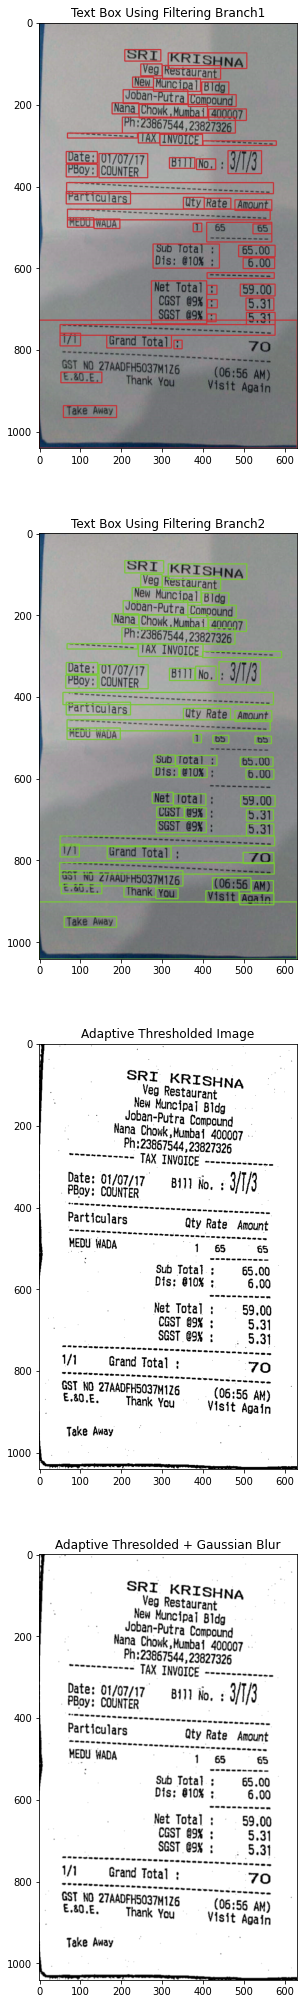

In [11]:
textBoxes_and_text = []
if os.path.isfile(TestImagePath):
    image = cv2.imread(TestImagePath)
    textboxesCtr1, imgViz1 = filterBranch1(image)
    textboxesCtr2, imgViz2, smoothenImg, thrImg = filterBranch2(image)
    
    grayImg = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
   

    textBoxes_and_text += get_text(textboxesCtr1, thrImg)
    textBoxes_and_text += get_text(textboxesCtr2, thrImg)
    print(len(textBoxes_and_text))
    # Display processed images
    fig=plt.figure(figsize=(16,36))
    row = 4
    col = 1
    fig.add_subplot(row, col, 1)
    plt.imshow(imgViz1)
    plt.title("Text Box Using Filtering Branch1")
    fig.add_subplot(row, col, 2)
    plt.imshow(imgViz2)
    plt.title("Text Box Using Filtering Branch2")
    fig.add_subplot(row, col, 3)
    plt.imshow(thrImg,cmap=cm.gray)
    plt.title("Adaptive Thresholded Image")
    fig.add_subplot(row, col, 4)
    plt.imshow(smoothenImg,cmap=cm.gray)
    plt.title("Adaptive Thresolded + Gaussian Blur")
else:
    print("File Not Present at path {}".format(TestImagePath))


Ww

 

 

ade - .

€.80.6,

Take Away

Particulars

PBoy:

Date:

 

Reuse. 8

 

 

 

MEDU

 


WADA

01/07/17
COUNTER

Grand Total

Nana

Ph: 23867544, 523827326

Joban-Putra

SRI

New


Chowk, Mumbat

Veg

Net Total]
CGST @9%
SGST @9%

Sub Total. ;
Dis: 610% ;

Muncipal

INVOICE

Restaurant.

KRISHNA

Bill


aty

Compound



Bldg


Rate






400007

31/3

Amount

65.00

59.00


5.31

5.31

65


GST NO 27AADFHS037H126

 

POT UA nine

 

Ww

 

€.80.6,

 

Reuse. 8

 

Take Away

PBoy:

Particulars

Date:

MEDU WADA

 


01/07/17
COUNTER

Grand Total

Nana

Ph: 23867544, 523827326

Joban-Putra

Thank

SRI

New Huncipal

TAX INVOICE


Veg


Dis:

Sub

You

SGST 69%

CGST

Restaurant

KRISHNA

Bil]

Total

Total:

810%

Qty Rate


Compound



Bldg


Visit

400007

(06:56

65

Wf

Amount

Again

65.00

59.00

70

6.00

5.31

5.31

AN)

65



Ww

 

 

ade - .

€.80.6,

T

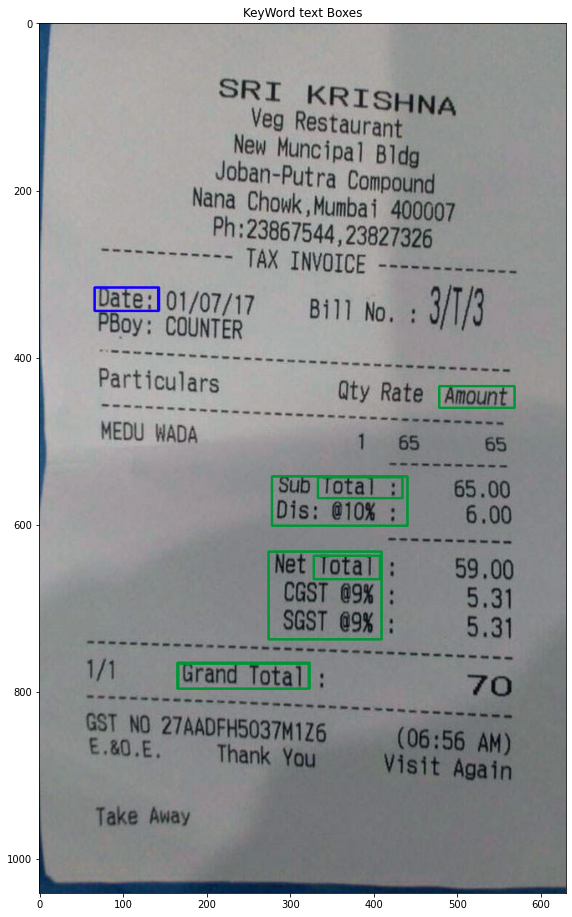

In [12]:
# Display Text Detected
detectedText = ""
for textBox, text in textBoxes_and_text:
    print(text)
    detectedText += "\n" + text

if len(detectedText)==0:
    print("PyTessarect was not able detect any text !")
else:
    print(detectedText)
    print("-------- Identifying KeyWords like Date and Amount ------------")

    dateBox, amountBox,  date, imgViz3 =get_keywords_and_keywordBoxes(textBoxes_and_text, image)

    fig=plt.figure(figsize=(16,16))
    plt.imshow(imgViz3)
    plt.title("KeyWord text Boxes")    